# 4. CNN(Convolution Neural Network)
> 이미지 전체를 한 번에 계산 X -> 국소적 부분을 계산 => 시간&자원 절약, 세밀한 부분까지 분석

- 이미지나 영상 처리, 음성인식
- 입력층 -> 합성곱층(Conv) -> 풀링층(Pooling) -> 완전연결층(FC) -> 출력층
- 합성층과 풀링층을 거치면서 이미지의 주요 특성 벡터( feature vector)를 추출

### 구조
- 이미지: 높이(height), 너비(width), 채널(channel) -> 3차원 데이터
- 합성곱층(Convolutional layer)
  - 데이터의 특성 추출
  - 커널(kernel)이나 필터 사용 -> 특징 추출 -> 특성 맵(feature map)
  - 스트라이드(stride)라는 간격을 이용해 이동
  - 입력 = (W, H, D)
  - 하이퍼파라미터
    - 필터 개수: K
    - 필터 크기: F
    - 스트라이드: S
    - 패딩: P
  - 출력
    - W = (W - F + 2P) / S+1
    - H = (W - F + 2P) / S+1
    - D = K
  - 풀링층(Pooling layer)
    - 특성 맵의 차원을 다운 샘플링 (이미지 축소)
    - 최대 풀링(max pooling)과 평균 풀링(avgerage pooling)이 대표적임
    - 출력
      - W = (W - F) / S+1
      - H = (H - F) / S+1
      - D = D
    - 완결 연결층(Fully Connected layer)    
      - 3차원 벡터 -> 1차원 벡터 (flatten)
    - 출력층
      - 소프트맥스 활성 함수 활용
      - 각 레이블에 속할 확률 출력

## 4.1 CNN with Fashion MNIST
- https://www.kaggle.com/datasets/zalando-research/fashionmnist

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# 데이터셋
train_dataset = torchvision.datasets.FashionMNIST("../data/", download=True, transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("../data/", download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [3]:
# Loader
train_loader = DataLoader(train_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)

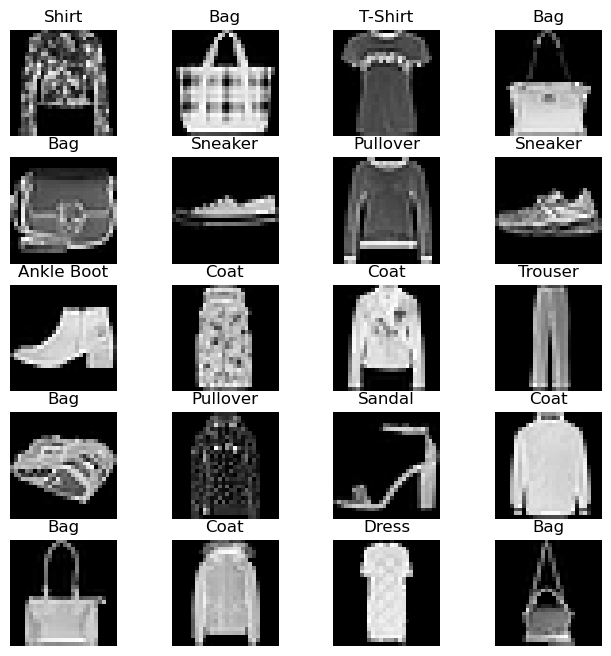

In [4]:
# Label maps
label_maps = {0:"T-Shirt", 1:"Trouser", 2:"Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle Boot"}

fig = plt.figure(figsize=(8, 8))
for idx in range(1, 4*5+1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0, :, :]
    fig.add_subplot(5, 4, idx)
    plt.title(label_maps[train_dataset[img_xy][1]])
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [5]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
    def forward(self, input_data):
        out = input_data.view(-1, 28*28)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

### torch.functional.xx vs nn.xx

In [ ]:
# nn.xx
inputs = torch.randn(64, 3, 244, 244)
conv = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
outputs = conv(inputs)
layer = nn.Conv2d(1, 1, 3)

In [ ]:
# nn.functional -> Sequential에 위치 불가
inputs = torch.randn(64, 3, 244, 244)
weight = torch.randn(64, 3, 3, 3)
bias = torch.randn(64)
outputs = F.conv2d(inputs, weight, bias, padding=1) # 가중치 수동 전달 -> 가중치를 새롭게 정의

### 하이퍼파라미터

In [6]:
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [7]:
torch.cuda.empty_cache()
# train
cnt = 0
loss_list = []
iter_list = []
acc_list = []
pred_list = []
labels_list = []

for epoch in range(5):
    for img, label in train_loader:
        img, label = img.to(device), label.to(device)
        train = Variable(img.view(100, 1, 28, 28))
        label = Variable(label)
        #
        outputs = model(train)
        loss = criterion(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cnt += 1
        #
        if not (cnt%50):
            total, correct = 0, 0
            for img, label in test_loader:
                img, label = img.to(device), label.to(device)
                labels_list.append(label)
                test = Variable(img.view(100, 1, 28, 28))
                outputs = model(test)
                pred = torch.max(outputs, 1)[1].to(device)
                pred_list.append(pred)
                correct += (pred==label).sum()
                total += len(label)
            acc = correct*100/total
            loss_list.append(loss.data)
            iter_list.append(cnt)
            acc_list.append(acc)
        if not (cnt%500):
            print(f"Iter: {cnt}, Loss: {loss.data:.3f}, Acc: {acc:.3f}")

Iter: 500, Loss: 0.612, Acc: 83.210
Iter: 1000, Loss: 0.505, Acc: 84.410
Iter: 1500, Loss: 0.338, Acc: 84.660
Iter: 2000, Loss: 0.362, Acc: 85.710
Iter: 2500, Loss: 0.315, Acc: 85.660
Iter: 3000, Loss: 0.287, Acc: 85.920


In [10]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [11]:
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [12]:
torch.cuda.empty_cache()
# train
cnt = 0
loss_list = []
iter_list = []
acc_list = []
pred_list = []
labels_list = []

for epoch in range(5):
    for img, label in train_loader:
        img, label = img.to(device), label.to(device)
        train = Variable(img.view(100, 1, 28, 28))
        label = Variable(label)
        #
        outputs = model(train)
        loss = criterion(outputs, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cnt += 1
        #
        if not (cnt%50):
            total, correct = 0, 0
            for img, label in test_loader:
                img, label = img.to(device), label.to(device)
                labels_list.append(label)
                test = Variable(img.view(100, 1, 28, 28))
                outputs = model(test)
                pred = torch.max(outputs, 1)[1].to(device)
                pred_list.append(pred)
                correct += (pred==label).sum()
                total += len(label)
            acc = correct*100/total
            loss_list.append(loss.data)
            iter_list.append(cnt)
            acc_list.append(acc)
        if not (cnt%500):
            print(f"Iter: {cnt}, Loss: {loss.data:.3f}, Acc: {acc:.3f}")

Iter: 500, Loss: 0.456, Acc: 88.260
Iter: 1000, Loss: 0.301, Acc: 86.960
Iter: 1500, Loss: 0.319, Acc: 87.910
Iter: 2000, Loss: 0.215, Acc: 89.580
Iter: 2500, Loss: 0.147, Acc: 89.120
Iter: 3000, Loss: 0.220, Acc: 88.950


## 4.2 전이학습 (Transfer Learning)
> 사전에 학습된 모델의 가중치를 가져와 새로운 문제에 맞게 수정해 사용하는 것

### 특성 추출(Feature Extractor)
- 새로운 출력층 추가
- 학습시 마지막 완전 연결층만 가중치 업데이트 (학습)

In [8]:
import os
import time
import copy
import glob
import cv2
import shutil
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

data_path = r"C:\Users\nuyhc\Desktop\Dev\AIphoria\data\catanddog"

In [4]:
transform = transforms.Compose([
    transforms.Resize([256, 256]),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.ImageFolder(os.path.join(data_path, "train"), transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, num_workers=8, shuffle=True)
print(len(train_dataset))

385


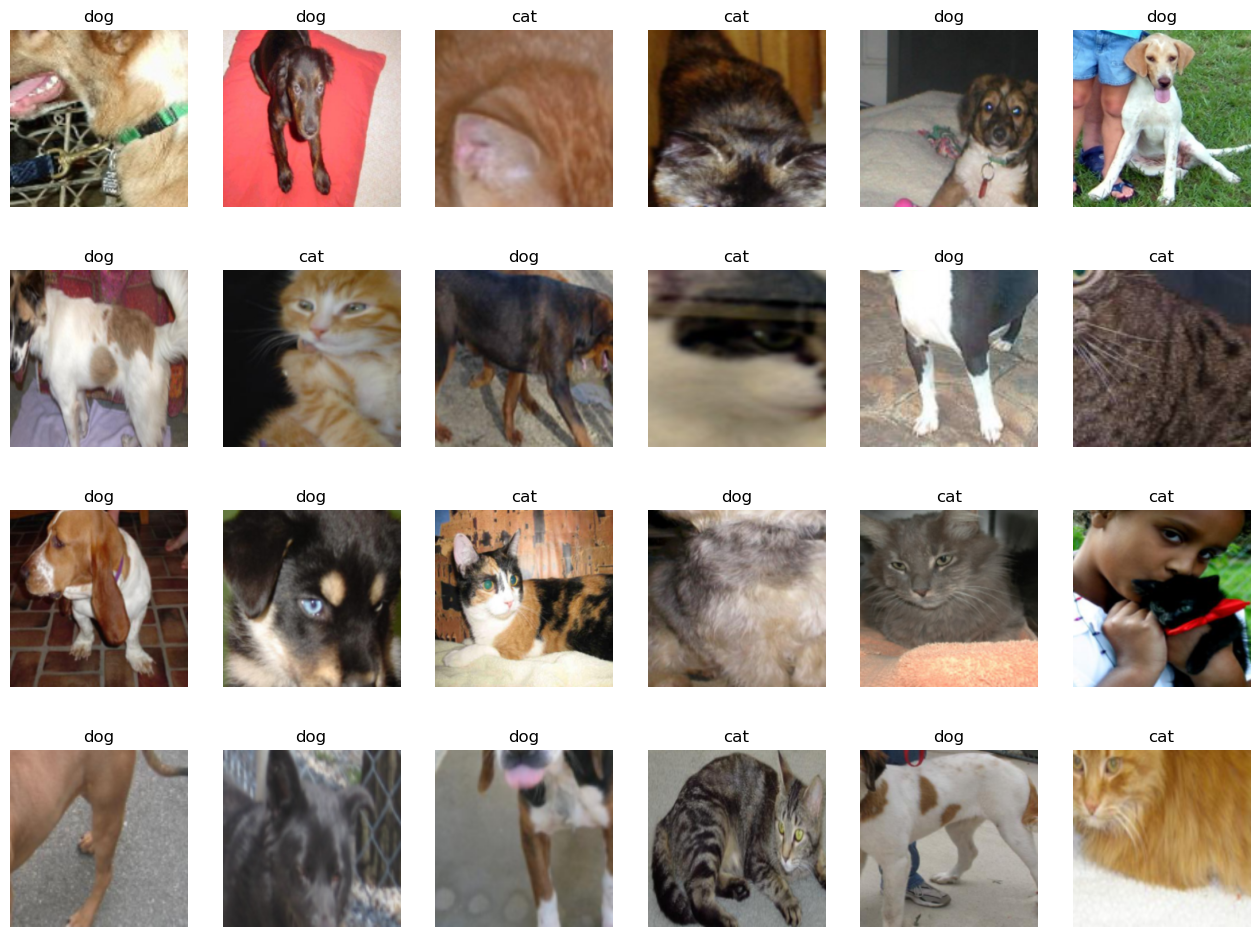

In [10]:
samples, labels = next(iter(train_loader))
classes = {0:"cat", 1:"dog"}
fig = plt.figure(figsize=(16, 24))
for idx in range(24):
    ax = fig.add_subplot(4, 6, idx+1)
    ax.set_title(classes[labels[idx].item()])
    ax.axis("off")
    ax.imshow(np.transpose(samples[idx].numpy(), (1, 2, 0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

In [12]:
samples.shape

torch.Size([32, 3, 224, 224])

In [15]:
samples[0].shape

torch.Size([3, 224, 224])

In [17]:
np.transpose(samples[0], (1, 2, 0)).shape

torch.Size([224, 224, 3])

In [21]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

In [22]:
# 파라미터 학습 고정 (학습X)
def set_params_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False # 역전파를 통한 변화를 계산할 필요가 없다는 의미 -> 업데이트 X
            
set_params_requires_grad(resnet18)

```text
# resnet18.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
...
    )
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=512, out_features=1000, bias=True)
)>
```

In [26]:
# 새로운 출력층 추가
resnet18.fc = nn.Linear(512, 2)

In [27]:
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[-0.0155, -0.0294,  0.0222,  ...,  0.0407,  0.0243, -0.0214],
        [-0.0315, -0.0283,  0.0190,  ..., -0.0008,  0.0433,  0.0309]])
fc.bias tensor([-0.0217, -0.0393])


In [30]:
for param in resnet18.fc.parameters():
    print(param)
    param.requires_grad = True

Parameter containing:
tensor([[-0.0155, -0.0294,  0.0222,  ...,  0.0407,  0.0243, -0.0214],
        [-0.0315, -0.0283,  0.0190,  ..., -0.0008,  0.0433,  0.0309]],
       requires_grad=True)
Parameter containing:
tensor([-0.0217, -0.0393], requires_grad=True)


In [33]:
optimizer = torch.optim.Adam(resnet18.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [47]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    start_time = time.time()
    acc_list, loss_list, best_acc = [], [], 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs-1}")
        print("-"*10)
        running_loss, running_corrects = 0.0, 0
        for inputs, labels in dataloaders:
            inputs, labels = inputs.to(device), labels.to(device)
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            #
            running_loss += loss.item()*inputs.size(0)
            running_corrects += torch.sum(preds==labels.data)
        epoch_loss = running_loss / len(dataloaders.dataset)
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print(f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc*100:.3f}%")
        #
        if epoch_acc > best_acc: best_acc = epoch_acc
        acc_list.append(epoch_acc.item())
        loss_list.append(epoch_loss)
        # 모델 저장
        torch.save(model.state_dict(), os.path.join(data_path, f"catNdot{epoch:2d}.pth"))
    time_elapsed = time.time() - start_time
    print(f"Training complete in {time_elapsed//60}m {time_elapsed%60}s")
    print(f"Best Acc: {best_acc}")
    return acc_list, loss_list

In [48]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
        print("\t", name)
#
optimizer = optim.Adam(params_to_update)
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

	 fc.weight
	 fc.bias
Epoch 0/12
----------
Loss: 0.2012, Acc: 90.130%
Epoch 1/12
----------
Loss: 0.1672, Acc: 93.506%
Epoch 2/12
----------
Loss: 0.1583, Acc: 94.286%
Epoch 3/12
----------
Loss: 0.1973, Acc: 90.909%
Epoch 4/12
----------
Loss: 0.1930, Acc: 91.948%
Epoch 5/12
----------
Loss: 0.1707, Acc: 93.247%
Epoch 6/12
----------
Loss: 0.1810, Acc: 91.688%
Epoch 7/12
----------
Loss: 0.2150, Acc: 90.909%
Epoch 8/12
----------
Loss: 0.1683, Acc: 92.727%
Epoch 9/12
----------
Loss: 0.1549, Acc: 93.766%
Epoch 10/12
----------
Loss: 0.1550, Acc: 93.766%
Epoch 11/12
----------
Loss: 0.1673, Acc: 92.727%
Epoch 12/12
----------
Loss: 0.1942, Acc: 90.390%
Training complete in 0.0m 31.566802740097046s
Best Acc: 0.9428571428571428


In [44]:
# eval
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

test_dataset = torchvision.datasets.ImageFolder(os.path.join(data_path, "test"), transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=1, shuffle=True)
print(len(test_dataset))

98


In [65]:
def eval_model(model, dataloaders, device):
    start_time = time.time()
    acc_list, best_acc = [], 0.0
    saved_models = glob.glob(data_path+"/*.pth")
    saved_models.sort()
    print(saved_models)
    for model_path in saved_models:
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        running_corrects = 0
        for inputs, labels in dataloaders:
            inputs, labels = inputs.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
            _, preds = torch.max(outputs.data, 1)
            preds[preds>=0.5] = 1
            preds[preds<0.5] = 0
            running_corrects += preds.eq(labels.to(device)).int().sum()
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print(f"Acc: {epoch_acc*100:.4f}")
        if epoch_acc>best_acc: best_acc = epoch_acc
        acc_list.append(epoch_acc.item())
        print()
    time_elapsed = time.time() - start_time
    print(f"Validation complete in {time_elapsed//60}m {time_elapsed%60}s")
    print(f"Best Acc {best_acc*100:.4f}")
    return acc_list

In [66]:
val_acc_hist = eval_model(resnet18, test_loader, device)

['C:\\Users\\nuyhc\\Desktop\\Dev\\AIphoria\\data\\catanddog\\catNdot 0.pth', 'C:\\Users\\nuyhc\\Desktop\\Dev\\AIphoria\\data\\catanddog\\catNdot 1.pth', 'C:\\Users\\nuyhc\\Desktop\\Dev\\AIphoria\\data\\catanddog\\catNdot 2.pth', 'C:\\Users\\nuyhc\\Desktop\\Dev\\AIphoria\\data\\catanddog\\catNdot 3.pth', 'C:\\Users\\nuyhc\\Desktop\\Dev\\AIphoria\\data\\catanddog\\catNdot 4.pth', 'C:\\Users\\nuyhc\\Desktop\\Dev\\AIphoria\\data\\catanddog\\catNdot 5.pth', 'C:\\Users\\nuyhc\\Desktop\\Dev\\AIphoria\\data\\catanddog\\catNdot 6.pth', 'C:\\Users\\nuyhc\\Desktop\\Dev\\AIphoria\\data\\catanddog\\catNdot 7.pth', 'C:\\Users\\nuyhc\\Desktop\\Dev\\AIphoria\\data\\catanddog\\catNdot 8.pth', 'C:\\Users\\nuyhc\\Desktop\\Dev\\AIphoria\\data\\catanddog\\catNdot 9.pth', 'C:\\Users\\nuyhc\\Desktop\\Dev\\AIphoria\\data\\catanddog\\catNdot10.pth', 'C:\\Users\\nuyhc\\Desktop\\Dev\\AIphoria\\data\\catanddog\\catNdot11.pth', 'C:\\Users\\nuyhc\\Desktop\\Dev\\AIphoria\\data\\catanddog\\catNdot12.pth']
Acc: 94.898

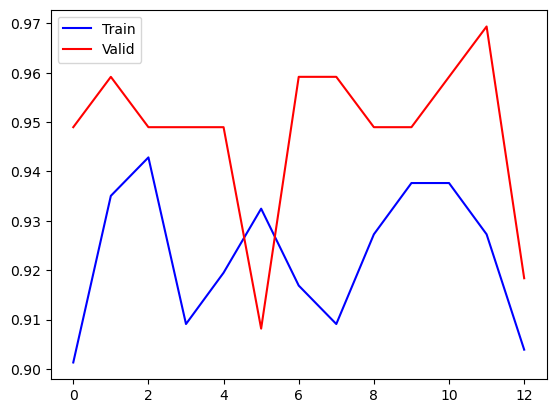

In [74]:
plt.plot(train_acc_hist, color="b")
plt.plot(val_acc_hist, color="r")
plt.legend(["Train", "Valid"])
plt.show()

### 미세 조정 기법 (Fine-Tuning)
- 동결층과 미동결층 선택
- 사전 학습된 모델을 목적에 맞게 재학습 or 학습된 가중치의 일부를 재학습

#### Tips
- 데이터셋이 크고 유사성이 작음 -> 모델 전체 재학습
- 데이터셋이 크고 유사성이 큼 -> 뒷부분과 분류기를 학습
- 데이터셋이 작고 유사성이 작음 -> 일부분과 분류기를 학습
- 데이터셋이 작고 유사성이 큼 -> 분류기 학습

## 4.3 특성맵 시각화
- https://nuyhc.github.io/posts/05_Conv/

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
class XAI(nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        # Features
        out = self.features(x)
        # CLF
        out = out.view(-1, 512)
        out = self.classifier(out)
        return F.log_softmax(out)

In [11]:
XAI = XAI()
XAI.to(device)
print(XAI)

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [12]:
# 특성맵 확인 목적
class LayerActivations:
    features = []
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output.detach().numpy()
    def remove(self):
        self.hook.remove()

torch.Size([1, 3, 100, 100])


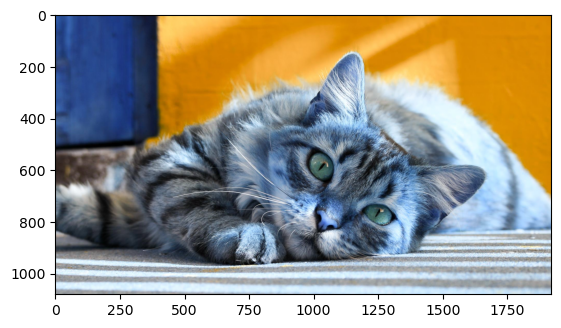

In [34]:
img = cv2.imread("../data/catanddog/cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)
print(img.shape)